# Downloading GraphAny

The first thing to do is to download the git repository of GraphAny, so, we are going to clone it.

In [1]:
!git clone https://github.com/DeepGraphLearning/GraphAny.git

Cloning into 'GraphAny'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 76 (delta 24), reused 40 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 576.89 KiB | 13.11 MiB/s, done.
Resolving deltas: 100% (24/24), done.


# Imports and Environment Setup

Then, we need to setup our environment manually using the `environment.yaml` file.

GraphAny relies on the usage of Conda, but not all the dependencies are avaiable on it, so we are going also to use pip.

Note that this process may take a while in colab.

In [2]:
import sys
import os
import subprocess
import yaml

data = {
    'name': 'graphany',
    'channels': [
        'pytorch',
        'pyg',
        'nvidia',
        'conda-forge',
        'defaults',
        'dglteam/label/cu118'
    ],
    'dependencies': [
        'python=3.10',
        'cudatoolkit=11.8',
        'pyg',
        'pytorch=2.2.1',
        'torchvision',
        'torchaudio',
        'torchdata=0.7.1',
        'torchmetrics=1.6.2',
        'transformers=4.49.0',
        'dgl',
        'lightning=2.*',
        'pydantic',
        'wandb',
        'rich',
        'hydra-core',
        'jupyter',
        'einops',
        'tensorboard',
        'pip',
        {
            'pip': [
                'ogb',
                'rootutils',
                'hydra_colorlog',
                # For time logging
                'codetiming',
                'humanfriendly',
                'torch_frame',
                'pytorch-frame[full]'
            ]
        }
    ]
}


sys.path.insert(0,'/content/GraphAny')


with open('GraphAny/environment.yaml', 'w') as file:
    yaml.dump(data, file)



!wget -O Miniconda.sh https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda.sh -b -p /usr/local/miniconda

os.environ['PATH'] = '/usr/local/miniconda/bin:' + os.environ['PATH']

!conda update conda -y -q
!source /usr/local/etc/profile.d/conda.sh
!conda init
!conda install -n root _license -y -q

!conda env create -f GraphAny/environment.yaml

Output streaming troncato alle ultime 5000 righe.







pillow-9.4.0         | 44.3 MB   | :  46% 0.4566892850833132/1 [00:34<00:13, 24.96s/it] 









pytorch-2.2.1        | 1.34 GB   | :  73% 0.7291009183130951/1 [00:34<00:11, 42.14s/it]










pillow-9.4.0         | 44.3 MB   | :  54% 0.5445005839140044/1 [00:34<00:07, 16.84s/it]









pytorch-2.2.1        | 1.34 GB   | :  73% 0.732497950983267/1 [00:34<00:10, 38.09s/it] 










pillow-9.4.0         | 44.3 MB   | :  62% 0.6245534547355581/1 [00:34<00:04, 12.07s/it]









pytorch-2.2.1        | 1.34 GB   | :  74% 0.7353269179895306/1 [00:34<00:10, 38.60s/it]










pillow-9.4.0         | 44.3 MB   | :  71% 0.7060169488315005/1 [00:34<00:02,  8.72s/it]









pytorch-2.2.1        | 1.34 GB   | :  74% 0.7380649944895689/1 [00:35<00:10, 38.53s/it]










pillow-9.4.0         | 44.3 MB   | :  81% 0.8135769735036321/1 [00:35<00:01,  5.86s/it]









pytorch-2.2.1        | 1.34 GB   | :  74% 0.7410416585684487/1 [0

In [3]:
%%bash
source activate graphany

python
import sys
import os
import subprocess
# some simple python commands
sys.path.append('/usr/local/lib/python3.10/site-packages')
print(sys.path)
# we check the python version and system paths
print("Python version")
print(sys.version)

['', '/env/python', '/usr/local/miniconda/envs/graphany/lib/python310.zip', '/usr/local/miniconda/envs/graphany/lib/python3.10', '/usr/local/miniconda/envs/graphany/lib/python3.10/lib-dynload', '/usr/local/miniconda/envs/graphany/lib/python3.10/site-packages', '/usr/local/lib/python3.10/site-packages']
Python version
3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


Sometimes colab needs to upload again the channels, so we need to do that manually one more time using bash command lines.

In [4]:
!source activate graphany && conda config --add channels pytorch
!source activate graphany && conda config --add channels pyg
!source activate graphany && conda config --add channels nvidia
!source activate graphany && conda config --add channels conda-forge
!source activate graphany && conda config --add channels dglteam/label/cu118

Now we can check all the dependencies of torch inside conda. This is important because there are some conflicts between dgl, torchdata, torchaudio and torchtriton most recent versions.

Thus make sure to have the correct versions of the following dependencies.

In [5]:
!source activate graphany && conda list torch

# packages in environment at /usr/local/miniconda/envs/graphany:
#
# Name                    Version                   Build  Channel
pytorch                   2.2.1           py3.10_cuda12.1_cudnn8.9.2_0    pytorch
pytorch-cuda              12.1                 ha16c6d3_6    pytorch
pytorch-frame             0.2.5                    pypi_0    pypi
pytorch-lightning         2.5.0.post0        pyh101cb37_0    conda-forge
pytorch-mutex             1.0                        cuda    pytorch
torch-frame               1.7.5                    pypi_0    pypi
torchaudio                2.2.1               py310_cu121    pytorch
torchdata                 0.7.1                     py310    pytorch
torchmetrics              1.6.2              pyhd8ed1ab_0    conda-forge
torchtriton               2.2.0                     py310    pytorch
torchvision               0.17.1              py310_cu121    pytorch


In [6]:
!source activate graphany && conda list transformers

# packages in environment at /usr/local/miniconda/envs/graphany:
#
# Name                    Version                   Build  Channel
transformers              4.49.0             pyhd8ed1ab_0    conda-forge


# Some Usefull functions

In this section we are going to define some functions that we will use in the following.

In [72]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import numpy as np
import pickle
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [8]:
def build_comparison_file(download_path, output_file):
    """
    Build a comparison file from the data loaded from a pickle file.

    Parameters:
    - download_path (str): Path to the input pickle file containing the data.
    - output_file (str): Path to the output CSV file where node information will be saved.

    Returns:
    - labels (torch.Tensor): Tensor containing the labels for the nodes.
    - node_features (torch.Tensor): Tensor containing the features for the nodes.
    - train_mask (torch.Tensor): Tensor indicating the training nodes.
    - val_mask (torch.Tensor): Tensor indicating the validation nodes.
    - test_mask (torch.Tensor): Tensor indicating the test nodes.
    - val_nodes (list): List of nodes in the validation set.
    - test_nodes (list): List of nodes in the test set.
    """

    with open(download_path, 'rb') as f:
        data = pickle.load(f)

    node_features = torch.tensor(data['node_features'])
    labels = torch.tensor(data['labels'])
    edges = torch.tensor(data['edges'])

    train_mask = torch.tensor(data['train_mask'])
    val_mask = torch.tensor(data['val_mask'])
    test_mask = torch.tensor(data['test_mask'])

    val_nodes = []
    test_nodes = []

    # Writing nodes and their respective classes in the test set
    with open(output_file, 'w') as f:
        f.write("Node,Class,Split\n")  # Header of the file
        for node in range(len(test_mask)):
            if val_mask[node]:
                val_nodes.append(node)
                f.write(f"{node},{labels[node].item()},val\n")  # Write node and class
            if test_mask[node]:
                test_nodes.append(node)
                f.write(f"{node},{labels[node].item()},test\n")  # Write node and class

    return labels, node_features, train_mask, val_mask, test_mask, val_nodes, test_nodes


In [9]:
def compute_AUROC(file_path, true_labels, val_nodes, test_nodes, auroc_labels):
    """
    Compute the AUROC for validation and test predictions.

    Parameters:
    - file_path (str): Path to the input file containing prediction scores.
    - true_labels (list): List of true labels for all nodes.
    - val_nodes (list): List of nodes in the validation set.
    - test_nodes (list): List of nodes in the test set.
    - auroc_labels (list): List of class labels for which to compute AUROC.

    Returns:
    - average_val_auroc (float): Average One-vs-Rest AUROC for the validation set.
    - average_test_auroc (float): Average One-vs-Rest AUROC for the test set.
    - binary_val_auroc (float): AUROC for the binary classification (0 vs 1) in the validation set.
    - binary_test_auroc (float): AUROC for the binary classification (0 vs 1) in the test set.
    """

    val_scores = {}
    test_scores = {}

    n_val_nodes = len(val_nodes)
    n_test_nodes = len(test_nodes)

    with open(file_path, 'r') as file:
        for index, line in enumerate(file):
            parts = line.split("\t")
            node = int(parts[0].split(':')[1])
            prediction = [float(x) for x in parts[1].strip('Prediction:[]').split()]

            if index < n_val_nodes:
                val_scores[node] = prediction
            elif index >= n_val_nodes and index < n_val_nodes + n_test_nodes:
                test_scores[node] = prediction

    # Select the validation and test true labels
    true_val_labels = []
    true_test_labels = []
    for node in val_nodes:
        true_val_labels.append(true_labels[node])
    for node in test_nodes:
        true_test_labels.append(true_labels[node])

    ### COMPUTING One-vs-rest AUROC ###
    # Validation AUROC
    val_aurocs = []
    for class_idx in auroc_labels:
        true_binary = [1 if label == class_idx else 0 for label in true_val_labels]
        pred_binary = [val_scores[node][class_idx] for node in val_nodes]
        val_aurocs.append(roc_auc_score(true_binary, pred_binary))

    # Test AUROC
    test_aurocs = []
    for class_idx in auroc_labels:
        true_binary = [1 if label == class_idx else 0 for label in true_test_labels]
        pred_binary = [test_scores[node][class_idx] for node in test_nodes]
        test_aurocs.append(roc_auc_score(true_binary, pred_binary))

    # One-vs-rest AUROC
    average_val_auroc = sum(val_aurocs) / len(val_aurocs) if val_aurocs else 0
    average_test_auroc = sum(test_aurocs) / len(test_aurocs) if test_aurocs else 0

    ### COMPUTING binary AUROC ####
    b_true_val_labels = []
    b_true_test_labels = []
    b_val_pred = []
    b_test_pred = []

    # Validation AUROC
    for node in val_nodes:  # Only consider nodes that should be classified as 0 or 1
        if true_labels[node] in [0, 1]:
            b_true_val_labels.append(true_labels[node])
            # Take only the probabilities for class 0 and 1, and normalize them
            prob_0_1 = val_scores[node][:2]
            prob_sum = sum(prob_0_1)
            b_val_pred.append(prob_0_1[1] / prob_sum)  # Probability for class 1

    # Test AUROC
    for node in test_nodes:  # Only consider nodes that should be classified as 0 or 1
        if true_labels[node] in [0, 1]:
            b_true_test_labels.append(true_labels[node])
            # Take only the probabilities for class 0 and 1, and normalize them
            prob_0_1 = test_scores[node][:2]
            prob_sum = sum(prob_0_1)
            b_test_pred.append(prob_0_1[1] / prob_sum)  # Probability for class 1

    # Binary AUROC
    binary_val_auroc = roc_auc_score(b_true_val_labels, b_val_pred) if b_val_pred else 0
    binary_test_auroc = roc_auc_score(b_true_test_labels, b_test_pred) if b_test_pred else 0

    return average_val_auroc, average_test_auroc, binary_val_auroc, binary_test_auroc


In [10]:
def clear_file_content(file_path):
    """
    Check if the file exists and clear its content if it does.

    Parameters:
    - file_path (str): Path to the file to be checked and cleared.
    """
    if os.path.isfile(file_path):
        with open(file_path, 'w') as file:
            file.truncate()  # Clear the file content
        print(f"The content of the file '{file_path}' has been cleared.")

In [66]:
def plot_confusion_matrices(metrics, title):
    """
    Plots confusion matrices for validation and test datasets.

    Parameters:
    metrics (dict): A dictionary containing the following keys:
        - 'val': A dictionary with validation metrics including:
            - 'TN (normalized)': True Negatives (normalized)
            - 'FP (normalized)': False Positives (normalized)
            - 'FN (normalized)': False Negatives (normalized)
            - 'TP (normalized)': True Positives (normalized)
        - 'test': A dictionary with test metrics including:
            - 'TN (normalized)': True Negatives (normalized)
            - 'FP (normalized)': False Positives (normalized)
            - 'FN (normalized)': False Negatives (normalized)
            - 'TP (normalized)': True Positives (normalized)

    title (str): The title to be displayed for the confusion matrices plot.

    Returns:
    None: The function displays the confusion matrices but does not return any value.
    """

    # Retrieve metrics for validation and test datasets
    val_metrics = metrics['val']
    test_metrics = metrics['test']

    # Confusion matrix for validation
    confusion_val = np.array([[val_metrics['TN (normalized)'], val_metrics['FP (normalized)']],
                               [val_metrics['FN (normalized)'], val_metrics['TP (normalized)']]])

    # Confusion matrix for test
    confusion_test = np.array([[test_metrics['TN (normalized)'], test_metrics['FP (normalized)']],
                                [test_metrics['FN (normalized)'], test_metrics['TP (normalized)']]])

    # Set up the figure format
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion matrix for validation
    sns.heatmap(confusion_val, annot=True, fmt=".2f", cmap="Purples", ax=axes[0],
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    axes[0].set_title('Confusion Matrix - Validation')
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('True Labels')

    # Confusion matrix for test
    sns.heatmap(confusion_test, annot=True, fmt=".2f", cmap="Purples", ax=axes[1],
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    axes[1].set_title('Confusion Matrix - Test')
    axes[1].set_xlabel('Predicted Labels')
    axes[1].set_ylabel('True Labels')

    # Set the title for the entire figure
    plt.suptitle(title, fontsize=16, color='firebrick')

    # Display the figure
    plt.tight_layout()
    plt.show()

In [106]:
def calculate_metrics(prediction_file, true_labels_file):
    """
    Calculates performance metrics from predicted labels and true labels.

    Parameters:
    prediction_file (str): The path to the file containing predicted labels.
    true_labels_file (str): The path to the file containing true labels.

    Returns:
    dict: A dictionary containing performance metrics for each split, including:
        - 'F1 Score Class 0': F1 Score for class 0
        - 'F1 Score Class 1': F1 Score for class 1
        - 'F1 Score Weighted': Weighted F1 Score
        - 'TP (normalized)': Normalized True Positives
        - 'TN (normalized)': Normalized True Negatives
        - 'FP (normalized)': Normalized False Positives
        - 'FN (normalized)': Normalized False Negatives
        - 'Precision': Precision score
        - 'Recall': Recall score
    """

    # Read predictions from the prediction file
    predictions = []
    with open(prediction_file, 'r') as pred_file:
        for line in pred_file:
            parts = line.strip().split('\t')
            predicted_class = int(parts[2].split(':')[1])  # Extract the predicted class
            predictions.append(predicted_class)

    # Read true labels from the true labels file
    true_labels = []
    with open(true_labels_file, 'r') as true_file:
        next(true_file)  # Skip the header
        for line in true_file:
            parts = line.strip().split(',')
            node = parts[0]
            class_label = int(parts[1])
            split = parts[2]
            true_labels.append((node, class_label, split))

    # Convert true labels to a DataFrame
    true_labels_df = pd.DataFrame(true_labels, columns=['Node', 'Class', 'Split'])

    # Extract true classes and splits
    true_classes = true_labels_df['Class'].values
    splits = true_labels_df['Split'].values

    unique_splits = np.unique(splits)

    # Calculate metrics for validation and test splits
    metrics = {}
    for split in unique_splits:
        indices = (splits == split)
        true_split_classes = true_classes[indices]
        pred_split_classes = [predictions[i] for i in range(len(predictions)) if indices[i]]

        # Calculate F1-Score for classes 0 and 1
        f1 = f1_score(true_split_classes, pred_split_classes, average=None)
        f1_class_0 = f1[0] if len(f1) > 0 else 0  # F1-Score for class 0
        f1_class_1 = f1[1] if len(f1) > 1 else 0  # F1-Score for class 1

        # Calculate Weighted F1-Score
        f1_weighted = f1_score(true_split_classes, pred_split_classes, average='weighted')

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(true_split_classes, pred_split_classes).ravel()

        # Precision computation
        p = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Recall computation
        r = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Normalize the confusion matrix
        total = tp + tn + fp + fn
        if total > 0:
            tn_norm = tn / total
            fp_norm = fp / total
            fn_norm = fn / total
            tp_norm = tp / total
        else:
            tn_norm = fp_norm = fn_norm = tp_norm = 0

        # Save the results
        metrics[split] = {
            'F1 Score Class 0': f1_class_0,
            'F1 Score Class 1': f1_class_1,
            'F1 Score Weighted': f1_weighted,
            'TP (normalized)': tp_norm,
            'TN (normalized)': tn_norm,
            'FP (normalized)': fp_norm,
            'FN (normalized)': fn_norm,
            'Precision': p,
            'Recall': r
        }

    return metrics

# Changing code in `run.py`

Since we want to obtain also the predictions performed by GraphAny on validation and test sets, we are going to change the code inside the `run.py` script.

In particular, we are going to append the predictions on a specific file which is going to be built inside our workspace.

In [11]:
new_code = """

import pytorch_lightning as pl
import rootutils

root = rootutils.setup_root(__file__, dotenv=True, pythonpath=True, cwd=False)
from graphany.utils import logger, timer
from graphany.utils.experiment import init_experiment
from graphany.data import GraphDataset, CombinedDataset
from graphany.model import GraphAny

import torch
import hydra
from omegaconf import DictConfig
import wandb
import numpy as np
import torchmetrics
from rich.pretty import pretty_repr

import os

mean = lambda input: np.round(np.mean(input).item(), 2)


class InductiveNodeClassification(pl.LightningModule):
    def __init__(self, cfg, combined_dataset, checkpoint=None):
        super().__init__()
        self.cfg = cfg
        if checkpoint:
            # Initialize from previous checkpoint using previous graphany config
            ckpt = torch.load(checkpoint, map_location="cpu")
            logger.critical(f"Loaded checkpoint at {checkpoint}")
            self.gnn_model = GraphAny(**ckpt["graph_any_config"])
            self.load_state_dict(ckpt["state_dict"])
        else:
            self.gnn_model = GraphAny(**cfg.graph_any)
        self.combined_dataset = combined_dataset
        self.attn_dict, self.loss_dict, self.res_dict = {}, {}, {}
        # Initialize accuracy metrics for validation and testing
        self.metrics = {}
        held_out_datasets = list(
            set(self.cfg._all_datasets) - set(self.cfg._trans_datasets)
        )  # 27 datasets in total
        self.heldout_metrics = [
            f"{setting}/{d.lower()[:4]}_{split}_acc"
            for split in ["val", "test"]
            for d in held_out_datasets
            for setting in ["trans", "ind"]
        ]
        for split in ("val", "test"):
            self.metrics[split] = {
                k: torchmetrics.Accuracy(task="multiclass", num_classes=v.num_class)
                for k, v in combined_dataset.eval_ds_dict.items()
            }

        self.criterion = torch.nn.CrossEntropyLoss()

    def on_train_end(self):
        checkpoint_path = f"{self.cfg.dirs.output}{self.cfg.dataset}_val_acc={self.res_dict['val_acc']}.pt"
        self.save_checkpoint(checkpoint_path)

    def save_checkpoint(self, file_path):
        checkpoint = {
            "state_dict": self.state_dict(),
            "optimizer_state_dict": [
                opt.state_dict() for opt in self.trainer.optimizers
            ],
            "graph_any_config": self.cfg.graph_any,
        }
        torch.save(checkpoint, file_path)
        logger.critical(f"Checkpoint saved to {file_path}")

    def get_metric_name(self, ds_name, split):
        if ds_name in self.cfg.train_datasets:
            return f"trans/{ds_name.lower()[:4]}_{split}_acc"
        else:
            return f"ind/{ds_name.lower()[:4]}_{split}_acc"

    def configure_optimizers(self):
        # start with all the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": self.cfg.weight_decay},
            {"params": nodecay_params, "weight_decay": 0.0},
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        logger.info(
            f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
        )
        logger.info(
            f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
        )

        if self.cfg.optimizer == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.cfg.lr)
        else:  # AdamW
            optimizer = torch.optim.AdamW(
                optim_groups,
                lr=self.cfg.lr,
                weight_decay=self.cfg.weight_decay,
            )
        return optimizer

    def on_fit_start(self):
        super().on_fit_start()
        # move all datasets to the correct GPU device
        print(f"moving train and eval datasets to {self.device}")
        self.combined_dataset.to(self.device)
        self.move_metrics_to_device()

    def move_metrics_to_device(self):
        for metrics_dict in self.metrics.values():
            for metric in metrics_dict.values():
                metric.to(self.device)

    def predict(self, ds, nodes, input, is_training=False):
        # Use preprocessed distance during evaluation
        dist = ds.dist if not is_training else None
        dist = dist.to(nodes.device)[nodes] if dist is not None else dist

        preds, attn = self.gnn_model(
            {c: chn_pred[nodes] for c, chn_pred in input.items()}, dist=dist
        )

        self.attn_dict.update(
            {
                f"Attention/{ds.name}-{c}": v
                for c, v in zip(self.cfg.feat_channels, attn)
            }
        )

        def softmax(logits):
          exp_logits = np.exp(logits - np.max(logits))
          return exp_logits / exp_logits.sum(axis=0)

        # Scrittura delle predizioni in un file
        with open("predictions.txt", "a") as file:  # Modalità append
            for node, pred in zip(nodes.cpu().numpy(), preds.cpu().numpy()):
                line = f"Node:{node}\tPrediction:{pred}\tClass:{np.argmax(softmax(pred))}"
                file.write(line + os.linesep)  # Scrive il nodo e la predizione

        return preds

    def training_step(self, batch, batch_idx):

        loss = {}
        for ds_name, batch_nodes in batch.items():
            ds = self.combined_dataset.train_ds_dict[ds_name]
            train_target_idx = batch_nodes
            # Batch nodes are not visible to avoid trivial solution and overfitting
            visible_nodes = list(
                set(ds.train_indices.tolist()) - set(batch_nodes.tolist())
            )
            ref_nodes = torch.tensor(visible_nodes, dtype=torch.long).to(self.device)
            ds_too_small = len(visible_nodes) < len(batch_nodes)
            if ds_too_small:
                # Visible nodes are too few, add first half of the batch to visible nodes
                ref_nodes = torch.cat((ref_nodes, batch_nodes[: len(batch_nodes) // 2]))

            input = ds.compute_channel_logits(
                ds.features, ref_nodes, sample=True, device=self.device
            )

            preds = self.predict(ds, train_target_idx, input, is_training=True)
            loss[f"loss/{ds_name}_loss"] = self.criterion(
                preds, ds.label[train_target_idx]
            )

        detached_loss = {k: v.detach().cpu() for k, v in loss.items()}
        avg_loss = mean(list(detached_loss.values()))
        self.loss_dict.update({"loss/avg_loss": avg_loss, **detached_loss})
        return sum(loss.values())

    def evaluation_step(self, split, batch, batch_idx):
        self.move_metrics_to_device()
        for ds_name, eval_idx in batch.items():
            if eval_idx is None:  # Skip if dataset is already evaluated (empty batch)
                continue
            ds = self.combined_dataset.eval_ds_dict[ds_name]
            ds.to(self.device)
            eval_idx.to(self.device)
            # Use unmasked feature for evaluation
            processed_feat = ds.unmasked_pred
            preds = self.predict(
                ds, eval_idx, processed_feat, is_training=False
            ).argmax(-1)
            self.metrics[split][ds_name].update(preds, ds.label[eval_idx])

    def validation_step(self, batch, batch_idx):
        self.evaluation_step("val", batch, batch_idx)

    def test_step(self, batch, batch_idx):
        self.evaluation_step("test", batch, batch_idx)

    def compute_and_log_metrics(self, split):
        # Compute metrics from collected outputs
        res = {}
        for ds_name, metric in self.metrics[split].items():
            metric_name = self.get_metric_name(ds_name, split)
            accuracy = metric.compute().cpu().numpy()
            res[metric_name] = np.round(accuracy * 100, 2)
            metric.reset()  # Reset metrics for the next epoch

        combined_res = {f"{split}_acc": np.round(sum(res.values()) / len(res), 2)}
        combined_res[f"trans_{split}_acc"] = mean(
            [v for k, v in res.items() if k.startswith("trans")]
        )
        combined_res[f"ind_{split}_acc"] = mean(
            [v for k, v in res.items() if k.startswith("ind")]
        )

        combined_res[f"heldout_{split}_acc"] = mean(
            [v for k, v in res.items() if k in self.heldout_metrics]
        )
        self.log_dict(res, prog_bar=False, logger=True, add_dataloader_idx=False)
        self.log_dict(
            combined_res, prog_bar=True, logger=True, add_dataloader_idx=False
        )
        self.res_dict.update({**res, **combined_res})

    def on_train_epoch_end(self):
        self.log_dict(self.loss_dict, on_epoch=True, prog_bar=True, logger=True)
        if len(self.attn_dict):
            self.log_dict(self.attn_dict, on_epoch=True, prog_bar=False, logger=True)

    def on_validation_epoch_end(self):
        self.compute_and_log_metrics("val")

    def on_test_epoch_end(self):
        self.compute_and_log_metrics("test")


@timer()
@hydra.main(config_path=f"{root}/configs", config_name="main", version_base=None)
def main(cfg: DictConfig):
    cfg, logger = init_experiment(cfg)
    # Define the default step metric for all metrics
    wandb.define_metric("*", step_metric="epoch")
    if torch.cuda.is_available() and cfg.preprocess_device == "gpu":
        preprocess_device = torch.device("cuda")
    else:
        preprocess_device = torch.device("cpu")

    def construct_ds_dict(datasets):
        datasets = [datasets] if isinstance(datasets, str) else datasets
        ds_dict = {
            dataset: GraphDataset(
                cfg,
                dataset,
                cfg.dirs.data_cache,
                cfg.train_batch_size,
                cfg.val_test_batch_size,
                cfg.n_hops,
                preprocess_device,
            )
            for dataset in datasets
        }
        return ds_dict

    train_ds_dict = construct_ds_dict(cfg.train_datasets)
    eval_ds_dict = construct_ds_dict(cfg.eval_datasets)

    combined_dataset = CombinedDataset(train_ds_dict, eval_ds_dict, cfg)

    model = InductiveNodeClassification(cfg, combined_dataset, cfg.get("prev_ckpt"))
    # Set up the checkpoint callback to save only at the end of training
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=cfg.dirs.output,  # specify where to save
        filename="final_checkpoint.pt",  # set a filename
        save_top_k=0,  # do not save based on metric, just save last
        save_last=True,  # ensures only the last checkpoint is kept
        save_on_train_epoch_end=True,  # save at the end of training epoch
    )
    trainer = pl.Trainer(
        max_epochs=cfg.total_steps,
        callbacks=[checkpoint_callback],
        limit_train_batches=cfg.limit_train_batches,
        check_val_every_n_epoch=cfg.eval_freq,
        logger=logger,
        accelerator="gpu" if torch.cuda.is_available() and cfg.gpus > 0 else "cpu",
        default_root_dir=cfg.dirs.lightning_root,
    )
    dataloaders = {
        "train": combined_dataset.train_dataloader(),
        "val": combined_dataset.val_dataloader(),
        "test": combined_dataset.test_dataloader(),
    }
    if cfg.total_steps > 0:
        trainer.fit(
            model,
            train_dataloaders=dataloaders["train"],
            val_dataloaders=dataloaders["val"],
        )
    trainer.validate(model, dataloaders=dataloaders["val"])
    trainer.test(model, dataloaders=dataloaders["test"])
    final_results = model.res_dict
    logger.critical(pretty_repr(final_results))
    logger.wandb_summary_update(final_results, finish_wandb=True)


if __name__ == "__main__":
    main()

"""

In [12]:
path_name = 'GraphAny/graphany/run.py'
with open(path_name, 'w') as file:
    file.write(new_code)

# Implement the dataset interface and update `GraphDataset` class in `data.py`

In this section we are going to implement the function `load_relbench_dataset`. Note that this function will not download the data from an online repository, instead we are going to use our current workspace.

So, make sure to insert the `data.pkl` file inside the directory `\data\relbench`.

In [13]:
new_code = """

import logging
import os
import os.path
import os.path as osp
import re
import ssl
import sys
import urllib

import pandas as pd
import pickle
#from torch_frame import TensorFrame
import requests

import dgl
import dgl.function as fn
import numpy as np
import pytorch_lightning as pl
import torch
from hydra.utils import instantiate
from omegaconf import OmegaConf
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold._utils import (
    _binary_search_perplexity as sklearn_binary_search_perplexity,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from graphany.utils import logger, timer


def get_entropy_normed_cond_gaussian_prob(X, entropy, metric="euclidean"):

    #Parameters
    #----------
    #X:              The matrix for pairwise similarity
    #entropy:     Perplexity of the conditional prob distribution
    #Returns the entropy-normalized conditional gaussian probability based on distances.
    #-------


    # Compute pairwise distances
    perplexity = np.exp2(entropy)
    distances = pdist(X, metric=metric)
    distances = squareform(distances)

    # Compute the squared distances
    distances **= 2
    distances = distances.astype(np.float32)
    return sklearn_binary_search_perplexity(distances, perplexity, verbose=0)


def sample_k_nodes_per_label(label, visible_nodes, k, num_class):
    ref_node_idx = [
        (label[visible_nodes] == lbl).nonzero().view(-1) for lbl in range(num_class)
    ]
    sampled_indices = [
        label_indices[torch.randperm(len(label_indices))[:k]]
        for label_indices in ref_node_idx
    ]
    return visible_nodes[torch.cat(sampled_indices)]


def get_data_split_masks(n_nodes, labels, num_train_nodes, label_idx=None, seed=42):
    label_idx = np.arange(n_nodes)
    test_rate_in_labeled_nodes = (len(labels) - num_train_nodes) / len(labels)
    train_idx, test_and_valid_idx = train_test_split(
        label_idx,
        test_size=test_rate_in_labeled_nodes,
        random_state=seed,
        shuffle=True,
        stratify=labels,
    )
    valid_idx, test_idx = train_test_split(
        test_and_valid_idx,
        test_size=0.5,
        random_state=seed,
        shuffle=True,
        stratify=labels[test_and_valid_idx],
    )
    train_mask = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask = torch.zeros(n_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[valid_idx] = True
    test_mask[test_idx] = True

    return train_mask, val_mask, test_mask


def download_url(url: str, folder: str, log: bool = True, filename=None):
    #Modified from torch_geometric.data.download_url

    #Downloads the content of an URL to a specific folder.

    #Args:
        #url (str): The URL.
        #folder (str): The folder.
        #log (bool, optional): If :obj:`False`, will not print anything to the
            #console. (default: :obj:`True`)


    if filename is None:
        filename = url.rpartition("/")[2]
        filename = filename if filename[0] == "?" else filename.split("?")[0]

    path = osp.join(folder, filename)

    if osp.exists(path):  # pragma: no cover
        if log and "pytest" not in sys.modules:
            print(f"Using existing file {filename}", file=sys.stderr)
        return path

    if log and "pytest" not in sys.modules:
        print(f"Downloading {url}", file=sys.stderr)

    os.makedirs(osp.expanduser(osp.normpath(folder)), exist_ok=True)

    context = ssl._create_unverified_context()
    data = urllib.request.urlopen(url, context=context)

    with open(path, "wb") as f:
        # workaround for https://bugs.python.org/issue42853
        while True:
            chunk = data.read(10 * 1024 * 1024)
            if not chunk:
                break
            f.write(chunk)

    return path


'''
def load_relbench_dataset(url, raw_dir):
    # Converts relbench dataset to DGL Graph format
    # download_path = download_url(url, raw_dir)
    download_path = download_file_from_google_drive(url, raw_dir)

    with open(download_path, 'rb') as f:
        data = pickle.load(f)

    node_features = torch.tensor(data['node_features'])
    labels = torch.tensor(data['labels'])
    edges = torch.tensor(data['edges'])

    graph = dgl.graph((edges[:, 0], edges[:, 1]),
                      num_nodes=len(node_features), idtype=torch.int32)
    num_classes = len(labels.unique())
    train_mask, val_mask, test_mask = torch.tensor(data['train_mask']), torch.tensor(data['val_mask']), torch.tensor(
        data['test_mask'])

    return graph, labels, num_classes, node_features, train_mask, val_mask, test_mask
'''

def load_relbench_dataset(url, raw_dir):
    # Converts relbench dataset to DGL Graph format
    # download_path = download_url(url[0], raw_dir)
    # download_path = download_file_from_google_drive(url, raw_dir)

    with open(raw_dir, 'rb') as f:
        data = pickle.load(f)

    node_features = torch.tensor(data['node_features'])

    labels = torch.tensor(data['labels'])
    edges = torch.tensor(data['edges'])

    graph = dgl.graph((edges[:, 0], edges[:, 1]),
                      num_nodes=len(node_features), idtype=torch.int32)
    num_classes = len(labels.unique())
    train_mask, val_mask, test_mask = torch.tensor(data['train_mask']), torch.tensor(data['val_mask']), torch.tensor(
        data['test_mask'])

    return graph, labels, num_classes, node_features, train_mask, val_mask, test_mask


def load_heterophilous_dataset(url, raw_dir):
    # Wrap Heterophilous to DGL Graph Dataset format https://arxiv.org/pdf/2302.11640.pdf
    download_path = download_url(url, raw_dir)
    data = np.load(download_path)
    node_features = torch.tensor(data["node_features"])
    labels = torch.tensor(data["node_labels"])
    edges = torch.tensor(data["edges"])

    graph = dgl.graph(
        (edges[:, 0], edges[:, 1]), num_nodes=len(node_features), idtype=torch.int
    )
    num_classes = len(labels.unique())
    num_targets = 1 if num_classes == 2 else num_classes
    if num_targets == 1:
        labels = labels.float()
    train_masks = torch.tensor(data["train_masks"]).T
    val_masks = torch.tensor(data["val_masks"]).T
    test_masks = torch.tensor(data["test_masks"]).T

    return graph, labels, num_classes, node_features, train_masks, val_masks, test_masks


class CombinedDataset(pl.LightningDataModule):
    def __init__(self, train_ds_dict, eval_ds_dict, cfg):
        super().__init__()
        self.train_ds_dict = train_ds_dict
        self.eval_ds_dict = eval_ds_dict
        self.all_ds = list(self.train_ds_dict.values()) + list(
            self.eval_ds_dict.values()
        )
        self.cfg = cfg

    def to(self, device):
        for ds in self.all_ds:
            ds.to(device)

    def train_dataloader(self):
        sub_dataloaders = {
            name: ds.train_dataloader() for name, ds in self.train_ds_dict.items()
        }
        return pl.utilities.combined_loader.CombinedLoader(sub_dataloaders, "min_size")

    def val_dataloader(self):
        sub_dataloaders = {
            name: ds.val_dataloader() for name, ds in self.eval_ds_dict.items()
        }
        # Use max_size instead of max_size_cycle to avoid repeated evaluation on small datasets
        return pl.utilities.combined_loader.CombinedLoader(sub_dataloaders, "max_size")

    def test_dataloader(self):
        sub_dataloaders = {
            name: ds.test_dataloader() for name, ds in self.eval_ds_dict.items()
        }
        # Use max_size instead of max_size_cycle to avoid repeated evaluation on small datasets
        return pl.utilities.combined_loader.CombinedLoader(sub_dataloaders, "max_size")


class GraphDataset(pl.LightningDataModule):
    def __init__(
            self,
            cfg,
            ds_name,
            cache_dir,
            train_batch_size=256,
            val_test_batch_size=256,
            n_hops=1,
            preprocess_device=torch.device("cpu"),
            permute_label=False,
    ):
        super().__init__()
        self.cfg = cfg
        self.name = ds_name
        self.train_batch_size = train_batch_size
        self.permute_label = permute_label  # For checking label equivariance
        self.val_test_batch_size = val_test_batch_size
        self.preprocess_device = preprocess_device

        self.n_hops = n_hops

        self.data_source, ds_alias = cfg["_ds_meta_data"][ds_name].split(", ")
        self.gidtype = None
        self.dist = None
        self.unmasked_pred = None
        if self.data_source == "pyg":
            components = ds_alias.split(".")
            ds_init_args = {
                "_target_": f"torch_geometric.datasets.{ds_alias}",
                "root": f"{cfg.dirs.data_storage}{self.data_source}/{ds_alias}/",
            }
            if len(components) == 2:  # If sub-dataset
                ds_init_args["_target_"] = f"torch_geometric.datasets.{components[0]}"
                ds_init_args["name"] = components[1]
        elif self.data_source == "dgl":
            ds_init_args = {
                "_target_": f"dgl.data.{ds_alias}",
                "raw_dir": f"{cfg.dirs.data_storage}{self.data_source}/",
            }
        elif self.data_source == "ogb":
            ds_init_args = {
                "_target_": f"ogb.nodeproppred.DglNodePropPredDataset",
                "root": f"{cfg.dirs.data_storage}{self.data_source}/",
                "name": ds_alias,
            }
        elif self.data_source == "heterophilous":
            target = "graphany.data.load_heterophilous_dataset"
            url = f"https://raw.githubusercontent.com/yandex-research/heterophilous-graphs/main/data/{ds_alias}.npz"
            ds_init_args = {
                "_target_": target,
                "raw_dir": f"{cfg.dirs.data_storage}{self.data_source}/",
                "url": url,
            }
        elif self.data_source == "relbench":
            target = "graphany.data.load_relbench_dataset"
            ds_init_args = {
                "_target_": target,
                "raw_dir": f"{cfg.dirs.data_storage}{self.data_source}/{ds_alias}.pkl",
                "url" : "",
            }
        else:
            raise NotImplementedError(f"Unsupported {self.data_source=}")
        self.data_init_args = OmegaConf.create(ds_init_args)
        # self.cache_f_name = osp.join(
        #     cache_dir, f'{self.name}_{n_hops}')
        if cfg.get("feat_chn"):
            all_channels = "+".join([cfg.feat_chn, cfg.pred_chn])
            all_hops = re.findall(r"\d+", all_channels)
            n_hops = max(max([int(_) for _ in all_hops]), n_hops)

        self.split_index = 0
        (
            self.g,
            self.label,
            self.feat,
            self.train_mask,
            self.val_mask,
            self.test_mask,
            self.num_class,
        ) = self.load_dataset(self.data_init_args)
        self.n_nodes, self.n_edges = self.g.num_nodes(), self.g.num_edges()
        self.cache_f_name = osp.join(
            cache_dir,
            f"{self.name}_{n_hops}hop_selfloop={cfg.add_self_loop}_bidirected={cfg.to_bidirected}_split="
            f"{self.split_index}.pt",
        )

        self.dist_f_name = osp.join(
            cache_dir,
            f"{self.name}_{n_hops}hop_selfloop={cfg.add_self_loop}_bidirected={cfg.to_bidirected}_split="
            f"{self.split_index}_{cfg.feat_chn}_entropy={cfg.entropy}_dist.pt",
        )

        self.gidtype = self.g.idtype
        self.train_indices = self.train_mask.nonzero().view(-1)

        (
            self.features,
            self.unmasked_pred,
            self.dist,
        ) = self.prepare_prop_features_logits_and_dist_features(
            self.g, self.feat, n_hops=cfg.n_hops
        )
        # Remove the graph, as GraphAny doesn't use it in training
        del self.g
        del self.feat
        torch.cuda.empty_cache()

    def to(self, device):  # Supports nested dictionary
        def to_device(input):
            if input is None:
                return None
            elif isinstance(input, dict):
                return {key: to_device(value) for key, value in input.items()}
            elif isinstance(input, list):
                return [to_device(item) for item in input]
            elif hasattr(input, "to"):
                return input.to(device)
            else:
                return (
                    input  # Return as is if it's not a tensor or any nested structure
                )

        # Apply to_device to all attributes that may contain tensors
        attrs = [
            "label",
            "feat",
            "train_mask",
            "val_mask",
            "test_mask",
            "train_indices",
            "unmasked_pred",
        ]
        for attr in attrs:
            if hasattr(self, attr):
                setattr(self, attr, to_device(getattr(self, attr)))

    def load_dataset(self, data_init_args):
        dataset = instantiate(data_init_args)

        if self.data_source == "ogb":
            split_idx = dataset.get_idx_split()
            train_indices, valid_indices, test_indices = (
                split_idx["train"],
                split_idx["valid"],
                split_idx["test"],
            )
            # graph: dgl graph object, label: torch tensor of shape (num_nodes, num_tasks)
            g, label = dataset[0]
            label = label.view(-1)

            def to_mask(indices):
                mask = torch.BoolTensor(g.number_of_nodes()).fill_(False)
                mask[indices] = 1
                return mask

            train_mask, val_mask, test_mask = map(
                to_mask, (train_indices, valid_indices, test_indices)
            )

            num_class = label.max().item() + 1

            feat = g.ndata["feat"]
        elif self.data_source == "heterophilous":
            g, label, num_class, feat, train_mask, val_mask, test_mask = dataset
        elif self.data_source == "relbench":
            g, label, num_class, feat, train_mask, val_mask, test_mask = dataset
        elif self.data_source == "dgl":
            g = dataset[0]
            num_class = dataset.num_classes

            # get node feature
            feat = g.ndata["feat"]

            # get data split
            train_mask = g.ndata["train_mask"]
            val_mask = g.ndata["val_mask"]
            test_mask = g.ndata["test_mask"]

            label = g.ndata["label"]
        elif self.data_source == "pyg":
            g = dgl.graph((dataset.edge_index[0], dataset.edge_index[1]))
            n_nodes = dataset.x.shape[0]
            num_class = dataset.num_classes
            # get node feature
            feat = dataset.x
            label = dataset.y

            if (
                    hasattr(dataset, "train_mask")
                    and hasattr(dataset, "val_mask")
                    and hasattr(dataset, "test_mask")
            ):
                train_mask, val_mask, test_mask = (
                    dataset.train_mask,
                    dataset.val_mask,
                    dataset.test_mask,
                )
            else:
                if label.ndim > 1:
                    raise NotImplementedError(
                        "Multi-Label classification currently unsupported."
                    )
                logging.warning(
                    f"No dataset split found for {self.name}, splitting with semi-supervised settings!!"
                )
                train_mask, val_mask, test_mask = get_data_split_masks(
                    n_nodes, label, 20 * num_class, seed=self.cfg.seed
                )

                self.split_index = self.cfg.seed
        else:
            raise NotImplementedError(f"Unsupported {self.data_source=}")
        if train_mask.ndim == 1:
            pass  # only one train/val/test split
        elif train_mask.ndim == 2:
            # ! Multiple splits
            # Modified: Use the ${seed} split if not specified!
            split_index = self.data_init_args.get("split", self.cfg.seed)
            # Avoid invalid split index
            self.split_index = split_index = (split_index % train_mask.ndim)
            train_mask = train_mask[:, split_index].squeeze()
            val_mask = val_mask[:, split_index].squeeze()
            if test_mask.ndim == 2:
                test_mask = test_mask[:, split_index].squeeze()
        else:
            raise ValueError("train/val/test masks have more than 2 dimensions")
        print(
            f"{self.name} {g.num_nodes()} {g.num_edges()} {feat.shape[1]} {num_class} {len(train_mask.nonzero())}"
        )

        if self.cfg.add_self_loop:
            g = dgl.add_self_loop(g)
        else:
            g = dgl.remove_self_loop(g)
        if self.cfg.to_bidirected:
            g = dgl.to_bidirected(g)
        g = dgl.to_simple(g)  # Remove duplicate edges.
        return g, label, feat, train_mask, val_mask, test_mask, num_class

    def compute_linear_gnn_logits(
            self, features, n_per_label_examples, visible_nodes, bootstrap=False
    ):
        # Compute and save LinearGNN logits into a dict. Note the computation is on CPU as torch does not support
        # the gelss driver on GPU currently.
        preds = {}
        label, num_class, device = self.label, self.num_class, torch.device("cpu")
        label = label.to(device)
        visible_nodes = visible_nodes.to(device)
        for channel, F in features.items():
            F = F.to(device)
            if bootstrap:
                ref_nodes = sample_k_nodes_per_label(
                    label, visible_nodes, n_per_label_examples, num_class
                )
            else:
                ref_nodes = visible_nodes
            Y_L = torch.nn.functional.one_hot(label[ref_nodes], num_class).float()
            with timer(
                    f"Solving with CPU driver (N={len(ref_nodes)}, d={F.shape[1]}, k={num_class})",
                    logger.debug,
            ):
                W = torch.linalg.lstsq(
                    F[ref_nodes.cpu()].cpu(), Y_L.cpu(), driver="gelss"
                )[0]
            preds[channel] = F @ W

        return preds

    def compute_channel_logits(self, features, visible_nodes, sample, device):
        pred_logits = self.compute_linear_gnn_logits(
            {
                c: features[c]
                for c in set(self.cfg.feat_channels + self.cfg.pred_channels)
            },
            self.cfg.n_per_label_examples,
            visible_nodes,
            bootstrap=sample,
        )
        return {c: logits.to(device) for c, logits in pred_logits.items()}

    def prepare_prop_features_logits_and_dist_features(self, g, input_feats, n_hops):
        # Calculate Low-pass features containing AX, A^2X and High-pass features
        # (I-A)X, and (I-A)^2X
        if not os.path.exists(self.cache_f_name):
            g = g.to(self.preprocess_device)
            with timer(
                    f"Computing {self.name} message passing and normalized predictions to file {self.cache_f_name}",
                    logger.info,
            ):
                dim = input_feats.size(1)
                LP = torch.zeros(n_hops, g.number_of_nodes(), dim).to(
                    self.preprocess_device
                )
                HP = torch.zeros(n_hops, g.number_of_nodes(), dim).to(
                    self.preprocess_device
                )

                g.ndata["LP"] = input_feats.to(self.preprocess_device)
                g.ndata["HP"] = input_feats.to(self.preprocess_device)
                for hop_idx in range(n_hops):
                    # D^-1 A filter
                    g.update_all(fn.copy_u("LP", "temp"), fn.mean("temp", "LP"))

                    # (I - D^-1A) filter
                    g.update_all(fn.copy_u("HP", "temp"), fn.mean("temp", "HP_out"))
                    g.ndata["HP"] = g.ndata["HP"] - g.ndata["HP_out"]

                    LP[hop_idx] = g.ndata["LP"].clone()
                    HP[hop_idx] = g.ndata["HP"].clone()
                lp_feat_dict = {f"L{l + 1}": x for l, x in enumerate(LP)}
                hp_feat_dict = {f"H{l + 1}": x for l, x in enumerate(HP)}

                features = {"X": input_feats, **lp_feat_dict, **hp_feat_dict}
                unmasked_pred = self.compute_channel_logits(
                    features,
                    self.train_indices,
                    sample=False,
                    device=self.preprocess_device,
                )
                torch.save((features, unmasked_pred), self.cache_f_name)
        else:
            features, unmasked_pred = torch.load(self.cache_f_name, map_location="cpu")
        if not os.path.exists(self.dist_f_name):
            with timer(
                    f"Computing {self.name} conditional gaussian distances "
                    f"and save to {self.dist_f_name}",
                    logger.info,
            ):
                # y_feat: n_nodes, n_channels, n_labels
                y_feat = np.stack(
                    [unmasked_pred[c].cpu().numpy() for c in self.cfg.feat_channels],
                    axis=1,
                )
                # Conditional gaussian probability
                bsz, n_channel, n_class = y_feat.shape
                dist_feat_dim = n_channel * (n_channel - 1)
                # Conditional gaussian probability
                cond_gaussian_prob = np.zeros((bsz, n_channel, n_channel))
                for i in range(bsz):
                    cond_gaussian_prob[i, :, :] = get_entropy_normed_cond_gaussian_prob(
                        y_feat[i, :, :], self.cfg.entropy
                    )
                dist = np.zeros((bsz, dist_feat_dim), dtype=np.float32)

                # Compute pairwise distances between channels n_channels(n_channels-1)/2 total features
                pair_index = 0
                for c in range(n_channel):
                    for c_prime in range(n_channel):
                        if c != c_prime:  # Diagonal distances are useless
                            dist[:, pair_index] = cond_gaussian_prob[:, c, c_prime]
                            pair_index += 1

                dist = torch.from_numpy(dist)
                torch.save(dist, self.dist_f_name)
        else:
            dist = torch.load(self.dist_f_name, map_location="cpu")
        return features, unmasked_pred, dist

    def train_dataloader(self):
        return DataLoader(
            self.train_mask.nonzero().view(-1),
            batch_size=self.train_batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_mask.nonzero().view(-1), batch_size=self.val_test_batch_size
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_mask.nonzero().view(-1), batch_size=self.val_test_batch_size
        )

"""

In [14]:
path_name = 'GraphAny/graphany/data.py'
with open(path_name, 'w') as file:
    file.write(new_code)

# F1 Dataset Implementation

## Update `configs/data.yaml` metadata section

Here we build the yaml interface of our dataset. For this dataset we are going to use a file named `f1_3_classes.pkl`, which has inside the Formula 1 imported dataset from Relbench.

In [15]:
# we read the data.yaml file
file_path = 'GraphAny/configs/data.yaml'

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

# We add the F1 dataset metadata to the yaml file
data['_ds_meta_data']['F1'] = 'relbench, f1_3_classes'


with open(file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

# Testing GraphAny on F1 Dataset

Now we can successfully test GraphAny on our Formula 1 Dataset. Note that we can choose between four different checkpoints of GraphAny. In particular, we are going to test the model using three of these checkpoints.

We can see the checkpoints in the directory `GraphAny/checkpoints/`

We will see that the performances in terms of F1-score are the same, but the ROC AUC changes a little in depending on what checkpoint we are using.

## Testing on Wisconsin checkpoint

### Clearing output files

In [16]:
# First of all we clear our output files
file_path = '/content/predictions.txt'
clear_file_content(file_path)
file_path = '/content/true_labels.txt'
clear_file_content(file_path)

### Update `configs/data.yaml` dataset section

In [17]:
file_path = 'GraphAny/configs/data.yaml'

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)


# We add the new element to _dataset_lookup
data['_dataset_lookup']['F1Debug'] = {
    'train': ['Wisconsin'],
    'eval': ['F1']
}


with open(file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

### Running the model

In [18]:
script_path = "GraphAny/graphany/run.py"
dataset = "F1Debug" # we want to use the F1 dataset
# dataset = "Debug"
steps = 0 # we want to perform zero-shot, thus we impose zero training epochs
checkpoint_path = "GraphAny/checkpoints/graph_any_wisconsin.pt"

In [20]:
os.environ['HYDRA_FULL_ERROR'] = '1'
!source activate graphany && python {script_path} prev_ckpt={checkpoint_path} dataset={dataset} total_steps={steps}

[15:27:18] INFO     Logger initialized.                                                                                                                 logging.py:53
           INFO     Local_rank=0, working_dir=/content/temp/working_dir/Mar21-15:27-227c0c5b/                                                        experiment.py:56
Done loading data from cached files.
Wisconsin 251 515 1703 5 120
F1 97605 455432 300 3 66303
[15:27:19] INFO     Started Computing F1 message passing and normalized predictions to file                                                            logging.py:116
                    /content/data_cache/F1_2hop_selfloop=False_bidirected=True_split=0.pt at 03-21 15:27:19                                                          
[15:27:28] INFO     Finished Computing F1 message passing and normalized predictions to file                                                           logging.py:122
                    /content/data_cache/F1_2hop_selfloop=False_bidirected=Tr

In [21]:
f1_data_path = "data/relbench/f1_3_classes.pkl"
f1_labels = "true_labels.txt"
labels, node_features, train_mask, val_mask, test_mask, val_nodes, test_nodes = build_comparison_file(f1_data_path, f1_labels)

In [22]:
predictions_path = "predictions.txt"
auroc_labels = [0, 1]
ovr_auroc_val, ovr_auroc_test, b_auroc_val, b_auroc_test = compute_AUROC(predictions_path, labels, val_nodes, test_nodes, auroc_labels)

print(f"One-vs-Rest ROC AUC Val: {ovr_auroc_val*100:.2f}")
print(f"One-vs-Rest ROC AUC Test: {ovr_auroc_test*100:.2f}")
print(f"Binary ROC AUC Val: {b_auroc_val*100:.2f}")
print(f"Binary ROC AUC Test: {b_auroc_test*100:.2f}")

One-vs-Rest ROC AUC Val: 51.16
One-vs-Rest ROC AUC Test: 53.70
Binary ROC AUC Val: 53.70
Binary ROC AUC Test: 58.80


In [105]:
metrics = calculate_metrics(predictions_path, f1_labels)

0.46153846153846156
0.46153846153846156


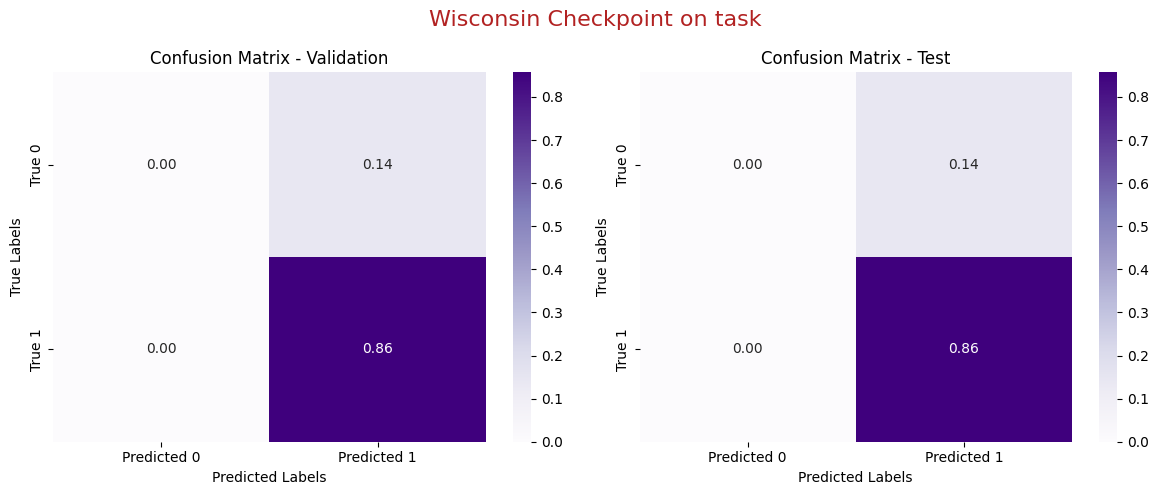

In [97]:
plot_confusion_matrices(metrics, title="Wisconsin Checkpoint on task")

In [98]:
print(f"\tPrecision and Recall values for Validation:\t")
print(f"Precision: {metrics['val']['Precision']:.2f}")
print(f"Precision: {metrics['val']['Recall']:.2f}")

print(f"\n\tPrecision and Recall values for Test:\t")
print(f"Precision: {metrics['test']['Precision']:.2f}")
print(f"Precision: {metrics['test']['Recall']:.2f}")

	Precision and Recall values for Validation:	
Precision: 0.86
Precision: 1.00

	Precision and Recall values for Test:	
Precision: 0.86
Precision: 1.00


In [101]:
print(f"\tF1 Score value for Validation:\t")
print(f"F1-Score for Class 0: {metrics['val']['F1 Score Class 0']:.2f}")
print(f"F1-Score for Class 1: {metrics['val']['F1 Score Class 1']:.2f}")
print(f"Weighted F1-Score: {metrics['val']['F1 Score Weighted']:.2f}")

print(f"\n\tF1 Score value for Test:\t")
print(f"F1-Score for Class 0: {metrics['test']['F1 Score Class 0']:.2f}")
print(f"F1-Score for Class 1: {metrics['test']['F1 Score Class 1']:.2f}")
print(f"Weighted F1-Score: {metrics['test']['F1 Score Weighted']:.2f}")

	F1 Score value for Validation:	
F1-Score for Class 0: 0.00
F1-Score for Class 1: 0.92
Weighted F1-Score: 0.79

	F1 Score value for Test:	
F1-Score for Class 0: 0.00
F1-Score for Class 1: 0.92
Weighted F1-Score: 0.79


In [107]:
from sklearn.dummy import DummyClassifier

def build_data_for_DummyClassifier(labels, node_features):

    X_train = []
    y_train = []

    for i in range(len(labels)):
      if labels[i] == 1 or label[i] == 0:
        X_train.append(node_features[i])
        y_train.append(labels[i])

    return X_train, y_train

In [ ]:
X_train_dummy, y_train_dummy = build_data_for_DummyClassifier(labels, node_features)

## Testing on Cora checkpoint

### Clearing output files

In [ ]:
# First of all we clear our output files
file_path = '/content/predictions.txt'
clear_file_content(file_path)
file_path = '/content/true_labels.txt'
clear_file_content(file_path)

The content of the file '/content/predictions.txt' has been cleared.
The content of the file '/content/true_labels.txt' has been cleared.


### Update `configs/data.yaml` dataset section

In [ ]:
file_path = 'GraphAny/configs/data.yaml'

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)


# We add the new element to _dataset_lookup
data['_dataset_lookup']['F1Debug'] = {
    'train': ['Cora'],
    'eval': ['F1']
}


with open(file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

### Running the model

In [ ]:
script_path = "GraphAny/graphany/run.py"
dataset = "F1Debug" # we want to use the F1 dataset
# dataset = "Debug"
steps = 0 # we want to perform zero-shot, thus we impose zero training epochs
checkpoint_path = "GraphAny/checkpoints/graph_any_cora.pt"

In [ ]:
os.environ['HYDRA_FULL_ERROR'] = '1'
!source activate graphany && python {script_path} prev_ckpt={checkpoint_path} dataset={dataset} total_steps={steps}

[15:34:05] INFO     Logger initialized.                                                                                                                 logging.py:53
           INFO     Local_rank=0, working_dir=/content/temp/working_dir/Mar8-15:34-f2cf3d44/                                                         experiment.py:56
Processing...
Done!
Cora 2708 10556 1433 7 140
[15:34:10] INFO     Started Computing Cora message passing and normalized predictions to file                                                          logging.py:116
                    /content/data_cache/Cora_2hop_selfloop=False_bidirected=True_split=0.pt at 03-08 15:34:10                                                        
           INFO     Finished Computing Cora message passing and normalized predictions to file                                                         logging.py:122
                    /content/data_cache/Cora_2hop_selfloop=False_bidirected=True_split=0.pt at 03-08 15:34:10, running time

In [ ]:
f1_data_path = "data/relbench/f1_3_classes.pkl"
f1_labels = "true_labels.txt"
labels, node_features, train_mask, val_mask, test_mask, val_nodes, test_nodes = build_comparison_file(f1_data_path, f1_labels)

In [ ]:
predictions_path = "predictions.txt"
auroc_labels = [0, 1]
ovr_auroc_val, ovr_auroc_test, b_auroc_val, b_auroc_test = compute_AUROC(predictions_path, labels, val_nodes, test_nodes, auroc_labels)

print(f"One-vs-Rest ROC AUC Val: {ovr_auroc_val*100:.2f}")
print(f"One-vs-Rest ROC AUC Test: {ovr_auroc_test*100:.2f}")
print(f"Binary ROC AUC Val: {b_auroc_val*100:.2f}")
print(f"Binary ROC AUC Test: {b_auroc_test*100:.2f}")

One-vs-Rest ROC AUC Val: 53.24
One-vs-Rest ROC AUC Test: 56.25
Binary ROC AUC Val: 56.94
Binary ROC AUC Test: 60.19


In [ ]:
metrics = calculate_metrics(predictions_path, f1_labels)

In [ ]:
plot_confusion_matrices(metrics, title="Cora Checkpoint on task")

In [ ]:
print(f"\tF1 Score value for Validation:\t")
print(f"F1-Score for Class 0: {metrics['val']['F1 Score Class 0']:.2f}")
print(f"F1-Score for Class 1: {metrics['val']['F1 Score Class 1']:.2f}")
print(f"Weighted F1-Score: {metrics['val']['F1 Score Weighted']:.2f}")

print(f"\n\tF1 Score value for Test:\t")
print(f"F1-Score for Class 0: {metrics['test']['F1 Score Class 0']:.2f}")
print(f"F1-Score for Class 1: {metrics['test']['F1 Score Class 1']:.2f}")
print(f"Weighted F1-Score: {metrics['test']['F1 Score Weighted']:.2f}")

## Testing on Arxiv checkpoint

### Clearing output files

In [ ]:
# First of all we clear our output files
file_path = '/content/predictions.txt'
clear_file_content(file_path)
file_path = '/content/true_labels.txt'
clear_file_content(file_path)

The content of the file '/content/predictions.txt' has been cleared.
The content of the file '/content/true_labels.txt' has been cleared.


### Update `configs/data.yaml` dataset section

In [ ]:
file_path = 'GraphAny/configs/data.yaml'

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)


# We add the new element to _dataset_lookup
data['_dataset_lookup']['F1Debug'] = {
    'train': ['Arxiv'],
    'eval': ['F1']
}


with open(file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

### Running the model

In [ ]:
script_path = "GraphAny/graphany/run.py"
dataset = "F1Debug" # we want to use the F1 dataset
# dataset = "Debug"
steps = 0 # we want to perform zero-shot, thus we impose zero training epochs
checkpoint_path = "GraphAny/checkpoints/graph_any_arxiv.pt"

In [ ]:
os.environ['HYDRA_FULL_ERROR'] = '1'
!source activate graphany && python {script_path} prev_ckpt={checkpoint_path} dataset={dataset} total_steps={steps}

[15:34:38] INFO     Logger initialized.                                                                                                                 logging.py:53
           INFO     Local_rank=0, working_dir=/content/temp/working_dir/Mar8-15:34-a1f37a8a/                                                         experiment.py:56
Downloaded 0.08 GB: 100% 81/81 [00:01<00:00, 69.82it/s]
Extracting /content/data/ogb/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...
100% 1/1 [00:00<00:00, 16844.59it/s]
Converting graphs into DGL objects...
100% 1/1 [00:00<00:00, 198.10it/s]
Saving...
Arxiv 169343 1166243 128 40 90941
[15:34:47] INFO     Started Computing Arxiv message passing and normalized predictions to file                                                         logging.py:116
                    /content/data_cache/Arxiv_2hop_selfloop=False_bidirected=True_split=0.pt at 03-08 15:34:47                                                       
[15:34:53] INF

In [ ]:
f1_data_path = "data/relbench/f1_3_classes.pkl"
f1_labels = "true_labels.txt"
labels, node_features, train_mask, val_mask, test_mask, val_nodes, test_nodes = build_comparison_file(f1_data_path, f1_labels)

In [ ]:
predictions_path = "predictions.txt"
auroc_labels = [0, 1]
ovr_auroc_val, ovr_auroc_test, b_auroc_val, b_auroc_test = compute_AUROC(predictions_path, labels, val_nodes, test_nodes, auroc_labels)

print(f"One-vs-Rest ROC AUC Val: {ovr_auroc_val*100:.2f}")
print(f"One-vs-Rest ROC AUC Test: {ovr_auroc_test*100:.2f}")
print(f"Binary ROC AUC Val: {b_auroc_val*100:.2f}")
print(f"Binary ROC AUC Test: {b_auroc_test*100:.2f}")

One-vs-Rest ROC AUC Val: 49.54
One-vs-Rest ROC AUC Test: 53.47
Binary ROC AUC Val: 55.56
Binary ROC AUC Test: 56.94


In [ ]:
metrics = calculate_metrics(predictions_path, f1_labels)

In [ ]:
plot_confusion_matrices(metrics, title="Cora Checkpoint on task")

In [ ]:
print(f"\tF1 Score value for Validation:\t")
print(f"F1-Score for Class 0: {metrics['val']['F1 Score Class 0']:.2f}")
print(f"F1-Score for Class 1: {metrics['val']['F1 Score Class 1']:.2f}")
print(f"Weighted F1-Score: {metrics['val']['F1 Score Weighted']:.2f}")

print(f"\n\tF1 Score value for Test:\t")
print(f"F1-Score for Class 0: {metrics['test']['F1 Score Class 0']:.2f}")
print(f"F1-Score for Class 1: {metrics['test']['F1 Score Class 1']:.2f}")
print(f"Weighted F1-Score: {metrics['test']['F1 Score Weighted']:.2f}")